In [1]:
# Libraries
import requests
import pandas as pd
from pathlib import Path

In [2]:
# Create request-headers
headers = {'User-Agent':"anupatil28@gmail.com"}


In [3]:
# Get json for company tickers
companyTickers = requests.get("https://www.sec.gov/files/company_tickers.json", headers=headers)

In [4]:
# Convert the json to pandas dataframe
companyData = pd.DataFrame(companyTickers.json()).T

In [5]:
companyData["cik_str"] = companyData["cik_str"].astype(str).str.zfill(10)

In [6]:
# get the cik value
cik = companyData[0:1].cik_str[0]

C:\Users\PC\AppData\Local\Temp\ipykernel_4424\3549573020.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cik = companyData[0:1].cik_str[0]


In [7]:
cik

'0000320193'

In [15]:
filingMetaData = requests.get(f"https://data.sec.gov/submissions/CIK{cik}.json", headers=headers)

In [17]:
allForms = pd.DataFrame.from_dict(filingMetaData.json()["filings"]["recent"])

In [39]:
# To get the earnings call
earningsData = allForms[allForms.form == '8-K']

,accessionNumber,filingDate,reportDate,acceptanceDateTime,act,form,fileNumber,filmNumber,items,size,isXBRL,isInlineXBRL,primaryDocument,primaryDocDescription


In [19]:
companyFacts = requests.get(f"https://data.sec.gov/api/xbrl/companyfacts/CIK{cik}.json", headers=headers)

In [21]:
# get the company concepts
companyConcepts = requests.get(f"https://data.sec.gov/api/xbrl/companyconcept/CIK{cik}/us-gaap/Assets.json",
                               headers=headers)

In [22]:
companyConcepts.json().keys()

dict_keys(['cik', 'taxonomy', 'tag', 'label', 'description', 'entityName', 'units'])

In [25]:
companyConcepts.json()['units']['USD'][0]

{'end': '2008-09-27',
 'val': 39572000000,
 'accn': '0001193125-09-153165',
 'fy': 2009,
 'fp': 'Q3',
 'form': '10-Q',
 'filed': '2009-07-22'}

In [26]:
assetData = pd.DataFrame.from_dict(companyConcepts.json()["units"]["USD"])

In [27]:
assets10Q = assetData[assetData.form == '10-Q']

In [28]:
assets10Q = assets10Q.reset_index(drop=True)

In [29]:
assets10Q

,end,val,accn,fy,fp,form,filed,frame
0,2008-09-27,39572000000,0001193125-09-153165,2009,Q3,10-Q,2009-07-22,NaN
1,2009-06-27,48140000000,0001193125-09-153165,2009,Q3,10-Q,2009-07-22,CY2009Q2I
2,2009-09-26,47501000000,0001193125-10-012085,2010,Q1,10-Q,2010-01-25,NaN
3,2009-09-26,47501000000,0001193125-10-088957,2010,Q2,10-Q,2010-04-21,NaN
4,2009-09-26,47501000000,0001193125-10-162840,2010,Q3,10-Q,2010-07-21,NaN
...,...,...,...,...,...,...,...,...
85,2023-07-01,335038000000,0000320193-23-000077,2023,Q3,10-Q,2023-08-04,CY2023Q2I
86,2023-09-30,352583000000,0000320193-24-000006,2024,Q1,10-Q,2024-02-02,NaN
87,2023-09-30,352583000000,0000320193-24-000069,2024,Q2,10-Q,2024-05-03,CY2023Q3I
88,2023-12-30,353514000000,0000320193-24-000006,2024,Q1,10-Q,2024-02-02,CY2023Q4I


<Axes: xlabel='end'>

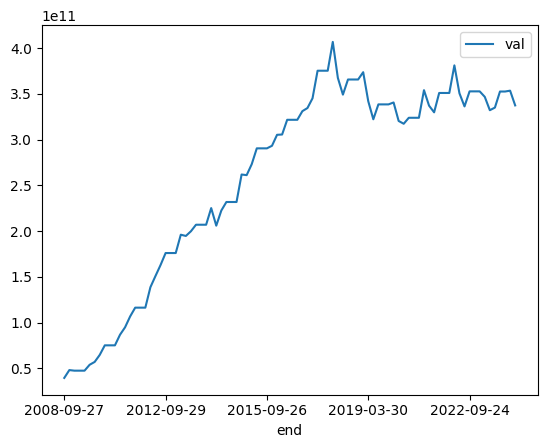

In [30]:
assets10Q.plot(x='end',y='val')

In [8]:
import requests
import json

def get_earnings_call_transcripts(cik):
    # Define the URL for the SEC EDGAR JSON data
    url = f"https://data.sec.gov/submissions/CIK{cik}.json"
    
    # Set the headers
    headers = {
        'User-Agent': 'anupatil28@gmail.com',
        'Accept-Encoding': 'gzip, deflate'
    }
    
    # Send the request to the SEC EDGAR database
    response = requests.get(url, headers=headers)
    #print(response)
    # Check if the request was successful
    if response.status_code == 200:
        # Parse the JSON response
        data = response.json()
        #print(data.keys())
        # Extract filings
        filings = data.get('filings', {}).get('recent', {})
        #print(filings['form'])
        # Filter for earnings call related filings (e.g., 8-K)
        transcripts = []
        for i, form in enumerate(filings.get('form', [])):
            #print(form=='8-K')
            if form == '8-K':
                form = filings.get('form',[])[i]
                primary_doc = filings.get('primaryDocument', [])[i]
                accession_num = filings.get('accessionNumber',[])[i]
                #print(primary_doc)
                #if 'earnings' in primary_doc.lower() or 'transcript' in primary_doc.lower():
                transcript = {
                    'Form': form,
                    'date': filings.get('filingDate', [])[i],
                    'url': f"https://www.sec.gov/Archives/edgar/data/{cik}/{accession_num.replace('-', '')}/{primary_doc}"
                }
                transcripts.append(transcript)
        
        return transcripts
    else:
        return f"Failed to fetch data: {response.status_code}"


In [9]:
# Example usage
#cik = '0000320193'  # Replace with the desired company's CIK
transcripts = get_earnings_call_transcripts(cik)


In [10]:
for transcript in transcripts:
    print(transcript)

{'Form': '8-K', 'date': '2024-05-03', 'url': 'https://www.sec.gov/Archives/edgar/data/0000320193/000114036124024352/ef20028273_8k.htm'}
{'Form': '8-K', 'date': '2024-05-02', 'url': 'https://www.sec.gov/Archives/edgar/data/0000320193/000032019324000067/aapl-20240502.htm'}
{'Form': '8-K', 'date': '2024-02-28', 'url': 'https://www.sec.gov/Archives/edgar/data/0000320193/000114036124010155/ny20022580x1_8k.htm'}
{'Form': '8-K', 'date': '2024-02-01', 'url': 'https://www.sec.gov/Archives/edgar/data/0000320193/000032019324000005/aapl-20240201.htm'}
{'Form': '8-K', 'date': '2023-11-02', 'url': 'https://www.sec.gov/Archives/edgar/data/0000320193/000032019323000104/aapl-20231102.htm'}
{'Form': '8-K', 'date': '2023-08-03', 'url': 'https://www.sec.gov/Archives/edgar/data/0000320193/000032019323000075/aapl-20230803.htm'}
{'Form': '8-K', 'date': '2023-05-10', 'url': 'https://www.sec.gov/Archives/edgar/data/0000320193/000114036123023909/ny20007635x4_8k.htm'}
{'Form': '8-K', 'date': '2023-05-04', 'url':

In [11]:
final_output = pd.DataFrame.from_dict(transcripts)

In [12]:
final_output.head()

,Form,date,url
0,8-K,2024-05-03,https://www.sec.gov/Archives/edgar/data/000032...
1,8-K,2024-05-02,https://www.sec.gov/Archives/edgar/data/000032...
2,8-K,2024-02-28,https://www.sec.gov/Archives/edgar/data/000032...
3,8-K,2024-02-01,https://www.sec.gov/Archives/edgar/data/000032...
4,8-K,2023-11-02,https://www.sec.gov/Archives/edgar/data/000032...


In [13]:
final_output.to_csv("earnings_call.csv")